In [1]:
import os
import math
import time
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fishUtilities as fu
import fishFits as ff
import surfaceAreaEstimators as sea

In [2]:
imagePath = r'.\Pictures\Robot'
databasePath = r'.\Databases'
figurePath = r'..\Journal Articles'
    
df = pd.read_excel(os.path.join(databasePath, 'robotSurfaceArea.xlsx'))
specimens = df['Photo Name'].tolist()
totalLengths = df['Total Length'].values
standardLengths = df['Standard Length'].values
widths = df['Width'].values
heights = df['Height'].values
mass = df['Mass'].values
surfaceAreas = df['Surface Area'].values
    
nacaSA = np.zeros(len(specimens))
polySA = np.zeros(len(specimens))
ESA = np.zeros(len(specimens))
ESAr = np.zeros(len(specimens))
ellipsoidSA = np.zeros(len(specimens))
partitionSA = np.zeros(len(specimens))
index = np.arange(0, len(specimens), 1)

In [3]:
for idx, specimen, tLength, sLength, width, height, weight in zip(index, specimens, totalLengths, standardLengths, widths, heights, mass):
    imagePathTop = fu.get_image_files(imagePath, specimen+'Top.PNG')
    #imagePathTopFull = fu.get_image_files(imagePath, specimen+'Top.PNG')
    imagePathSide = fu.get_image_files(imagePath, specimen+'SideNF.PNG')
    #imagePathCS = fu.get_image_files(imagePath, specimen+'CS.PNG')
    imagePathSideFull = fu.get_image_files(imagePath, specimen+'Side.PNG')
    
    # import images
    imageTop = cv2.imread(imagePathTop[0])
    #imageTopFull=cv2.imread(imagePathTopFull[0])
    imageSide = cv2.imread(imagePathSide[0])
    #imageCS = cv2.imread(imagePathCS[0])
    imageSideFull = cv2.imread(imagePathSideFull[0])
    
    # make a copy of the image
    sideImage = imageSide.copy()
    topImage = imageTop.copy()
    sideImageFull = imageSideFull.copy()
        
    # get contours
    cntsTop, hullTop = fu.get_contours(imageTop, 1)
    #cntsTopFull, hullTopFull = fu.get_contours(imageTopFull, 1)
    cntsSide, hullSide = fu.get_contours(imageSide, 1)
    #cntsCS, hullCS = fu.get_contours(imageCS, 1)
    cntsFull, hullFUll = fu.get_contours(imageSideFull, 1)
    
    # determine the most extreme points along the contour
    extSideLeft = tuple(cntsSide[cntsSide[:, :, 0].argmin()][0])
    extSideRight = tuple(cntsSide[cntsSide[:, :, 0].argmax()][0])
    extTopLeft = tuple(cntsTop[cntsTop[:, :, 0].argmin()][0])
    extTopRight = tuple(cntsTop[cntsTop[:, :, 0].argmax()][0])
    extTop = tuple(cntsFull[cntsFull[:, :, 1].argmin()][0])
    extBot = tuple(cntsFull[cntsFull[:, :, 1].argmax()][0])
    
    # Find the area ratio of fins and no fins
    areaFull = cv2.contourArea(cntsFull)
    areaNF = cv2.contourArea(cntsSide)
    areaRatio = (1-np.abs(areaNF/areaFull))
    
    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(imageTop.shape, cntsTop)
    #(cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(imageTopFull.shape, cntsTopFull)
    (cxSide, cySide), areaSide, topHullSide, bottomHullSide = fu.split_by_centroid_side(imageSide.shape, cntsSide)
    (cxFull, cyFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(imageSideFull.shape, cntsFull)
    #(cxCS, cyCS), aspectRatio, topHullCS, bottomHullCS = fu.split_by_centroid_cs(imageCS.shape, cntsCS)
    
    # get contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    #areaTopFull, tHullTopFull, bHullTopFull= fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    #scaleFactorCS, tHullCS, bHullCS = fu.scale_data(topHullCS, bottomHullCS)
        
    #areaTopRatio = 1-(areaTop/areaTopFull)
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    #maxPointsCS, minPointsCS = fu.get_min_max(tHullCS, bHullCS)
        
    dx = np.linspace(0, 1.0, 200)
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]),
                                                 np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    topPolyTop = np.poly1d(topFitTop)
    bottomPolyTop = np.poly1d(bottomFitTop)
    topPolySide = np.poly1d(topFitSide)
    bottomPolySide = np.poly1d(bottomFitSide)
        
    
    nacaSA[idx] = sea.surface_area_fusiform(topPolySide, bottomPolySide, xu, yu, sLength)
    nacaSA[idx] = nacaSA[idx] + (nacaSA[idx]*areaRatio)
    polySA[idx] = sea.surface_area_oval(dx, topPolySide, bottomPolySide, topPolyTop, bottomPolyTop, sLength)
    polySA[idx] = polySA[idx] + (polySA[idx]*areaRatio)
    _, ESA[idx], _, ESAr[idx], _ = sea.equivalentSpheroid(tLength, weight, 1025)
    ellipsoidSA[idx] = sea.ellipsoidApproximation(tLength, width, height)
    partitionSA[idx] = sea.partitionDisc(sLength, topPolySide, bottomPolySide, topPolyTop, bottomPolyTop)
    partitionSA[idx] = partitionSA[idx] + (partitionSA[idx]*areaRatio)

In [4]:
nacaError = -np.divide(surfaceAreas-nacaSA, surfaceAreas)*100
polyError = -np.divide(surfaceAreas-polySA, surfaceAreas)*100
ESAError = -np.divide(surfaceAreas-ESA, surfaceAreas)*100
ellipsoidError = -np.divide(surfaceAreas-ellipsoidSA, surfaceAreas)*100
partitionError = -np.divide(surfaceAreas-partitionSA, surfaceAreas)*100
        
output = {'Specimen':specimens, 'Total Lengths':totalLengths, 'Standard Lengths':standardLengths,
          'ActualSA':surfaceAreas, 'NACASA':nacaSA, 'PolySA':polySA, 'ESA':ESA, 'ESA_r':ESAr, 
          'Ellipsoid':ellipsoidSA, 'Partition':partitionSA}
    
outputDF = pd.DataFrame(data=output)

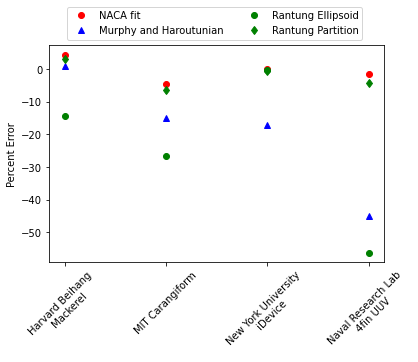

In [9]:
xlabels = ['Harvard Beihang\n Mackerel', 'MIT Carangiform', 'New York University\n iDevice', 'Naval Research Lab\n 4fin UUV']
fig1, ax1 = plt.subplots()
ax1.plot(specimens, nacaError, 'ro', label='NACA fit')
#ax1.plot(specimens, polyError, 'rd', label='Poly fit')
ax1.plot(specimens, ESAError, 'b^', label='Murphy and Haroutunian')
ax1.plot(specimens, ellipsoidError, 'go', label='Rantung Ellipsoid')
ax1.plot(specimens, partitionError, 'gd', label='Rantung Partition')
ax1.set_ylabel('Percent Error')
ax1.set_xticklabels(xlabels, rotation=45)
ax1.legend(bbox_to_anchor=(0.95, 1.20), ncol=2)
fig1.savefig('Robot Comparison.pdf', bbox_inches='tight')

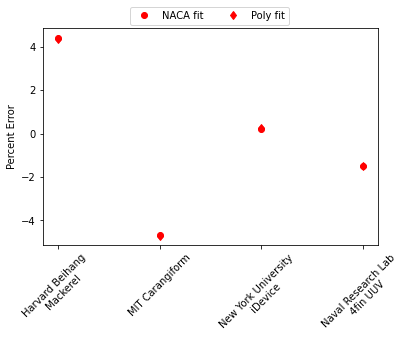

In [11]:
xlabels = ['Harvard Beihang\n Mackerel', 'MIT Carangiform', 'New York University\n iDevice', 'Naval Research Lab\n 4fin UUV']
fig2, ax2 = plt.subplots()
ax2.plot(specimens, nacaError, 'ro', label='NACA fit')
ax2.plot(specimens, polyError, 'rd', label='Poly fit')
ax2.set_ylabel('Percent Error')
ax2.set_xticklabels(xlabels, rotation=45)
ax2.legend(bbox_to_anchor=(0.75, 1.12), ncol=2)
fig2.savefig('Two Method Comparison.pdf', bbox_inches='tight')